In [1]:
 '''
Author information:
Joey R. Muffoletto
University of Texas at Austin
Autonomous Systems Group
jrmuff@utexas.edu
'''

'\nAuthor information:\nJoey R. Muffoletto\nUniversity of Texas at Austin\nAutonomous Systems Group\njrmuff@utexas.edu\n'

In [2]:
import realtime_manager as rm 
import graph_manager as gm
import reworked_graph as rg
import copy
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin'

c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
'''
manager configurations

traffic test globals
'''
NUM_TOWERS = 5
TAU_MAX = 10
TAU = 4

LOW_TRAFFIC_MULTIPLIER = 1
HIGH_TRAFFIC_MULTIPLIER = 3

MIN_LOW_TRAFFIC = 0
MAX_LOW_TRAFFIC = LOW_TRAFFIC_MULTIPLIER * NUM_TOWERS

MIN_HIGH_TRAFFIC = MAX_LOW_TRAFFIC
MAX_HIGH_TRAFFIC = HIGH_TRAFFIC_MULTIPLIER * NUM_TOWERS

MIN_TTL = 0
MAX_TTL = 3

DEFAULT_EMPTY_STATE = rg.State((),(),{"0" : 6})
rm.configure_realtime(tau=TAU, override_default_empty_state=DEFAULT_EMPTY_STATE)

HIGH_TRAFFIC_FREQUENCY = .25 # use rand.random() = [0.0, 1.0], or, just add this value until = 1 then reset

NUM_TIME_STEPS = 40



In [4]:
'''
Input generation functions

low traffic is some random number between min_low_traffic and max_low_traffic, high traffic is the same with high

choose a random tower index everytime we add one

high traffic occurs everytime HIGH_TRAFFIC_FREQUENCY * TIME_STEPS is a whole number

TTL is a random number between MIN_TTL and MAX_TTL
'''
import random
random.seed(10)
def generate_traffic(min_traffic, max_traffic):
    additional_requests_dict = dict()
#     counter = 0
    requests_to_add = random.randint(min_traffic, max_traffic)
    for i in range(requests_to_add):
#         if counter == NUM_TOWERS:
#             counter = 0
#         tower_to_add_to = counter
#         counter+=1
        tower_to_add_to = random.randint(0, NUM_TOWERS-1) # NUM_TOWERS is OOB
        request_to_add = ('no_pref', random.randint(MIN_TTL, MAX_TTL))
#         request_to_add = ('no_pref', 5)
        if tower_to_add_to in additional_requests_dict:
            additional_requests_dict[tower_to_add_to].append(request_to_add)
        else:
            additional_requests_dict[tower_to_add_to] = [request_to_add]
    return additional_requests_dict
            
def generate_low_traffic():
    return generate_traffic(MIN_LOW_TRAFFIC, MAX_LOW_TRAFFIC)
    
def generate_high_traffic():
    return generate_traffic(MIN_HIGH_TRAFFIC, MAX_HIGH_TRAFFIC)

In [5]:
'''
Input Generation
'''
input = []
high_traffic_counter = 0
for time in range(NUM_TIME_STEPS):
    if high_traffic_counter == 1:
        high_traffic_counter = 0
        input.append([generate_high_traffic()])
    else:
        high_traffic_counter += HIGH_TRAFFIC_FREQUENCY
        input.append([generate_low_traffic()])
        
initial_system = [copy.deepcopy(gm.return_tower(0, 1, [],[6])) for i in range(NUM_TOWERS)]

In [6]:
'''
Input statistics:
'''
requests_per_tower = [0 for i in range(NUM_TOWERS)]
for time_step in range(len(input)):
    for i in range(NUM_TOWERS):
        if i in input[time_step][0]:
            requests_per_tower[i]+=len(input[time_step][0][i])
for i in range(NUM_TOWERS):
    print("tower " + str(i) + "has " + str(requests_per_tower[i]) + " requests")

tower 0has 28 requests
tower 1has 35 requests
tower 2has 29 requests
tower 3has 33 requests
tower 4has 34 requests


In [7]:
'''
INPUT SAVING (DO NOT RE-RUN WILLY NILLY MY FRIEND)
'''
input_copy = copy.deepcopy(input)
# for _dict in input_copy:
#     print(_dict)

initial_system_copy = copy.deepcopy(initial_system)

In [8]:
'''
data collection
'''
_completed_states_per_tau = [[] for i in range(TAU_MAX)]
_timing_info_per_tau = [[] for i in range(TAU_MAX)]
for _tau in range(TAU_MAX):
    rm.configure_realtime(tau=_tau, override_default_empty_state=DEFAULT_EMPTY_STATE)
    traces, timings = rm.main_loop(initial_system_copy, copy.deepcopy(input_copy))
    _completed_states_per_tau[_tau] = copy.deepcopy(traces)
    _timing_info_per_tau[_tau] = copy.deepcopy(timings)
    gm.reset_globals()
#     print(traces)
    # _completed_states, _timing_info = rm.main_loop(initial_system_copy, input_copy)


additional requests for tower 0 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 3 = [('no_pref', 0), ('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (0, 2) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 4} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 1 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',

Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_pref', 3)]
[('no_pref', 3)]
[('no_pref', 2)]
additional requests for tower 3 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (2, 3) Port states of :: {'0': -7} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0': -8} Labels :: ('VALID', 'OVERFLOWED_PORT')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': -9} Labels :: ('VALID', 'FINISH', 'OVERFLOWED_PORT')  
]
additional requests for tower 2 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0'

]
additional requests for tower 4 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (4,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_pref', 0)]
[('no_pref', 1)]
[('no_pref', 3)]
additional requests for tower 4 = [('no_pref', 3), ('no_pref', 0)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (3, 0) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0': 4} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 3} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 0 = [('no_pref', 3), ('no_pref', 1), ('no_pref', 3)]
Full trace including new requests = [State currently has requests 

]
[('no_pref', 1), ('no_pref', 1)]
[('no_pref', 0), ('no_pref', 1), ('no_pref', 3)]
[('no_pref', 0)]
[('no_pref', 2), ('no_pref', 0)]
[('no_pref', 1)]
additional requests for tower 1 = [('no_pref', 0)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (1, 0) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (-1,) Port states of :: {'0': 4} Labels :: ()  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 3} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 2 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (1, 3, 3) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (2, 2) Port states of :: {'0': 4} Labels :: ('VALID',)  
, State currently has requests :: (

]
additional requests for tower 0 = [('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 2 = [('no_pref', 0)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref', 'no_pref') Time states of :: (1, 1, 1, 0) Port states of :: {'0': 4} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (0, 0, -1) Port states of :: {'0': 3} Labels :: ()  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (-1, -1) Port states of :: {'0': 2} Labels :: ()  
, State currently has requests :: ('no_pref',) Time states of :: (-1,) Port states of :: {'0': 1} Labels :: ()  
, State currently has requests :: () Time states 

]
[('no_pref', 2)]
additional requests for tower 3 = [('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 2 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (4,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 1 = [('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_

]
[('no_pref', 0), ('no_pref', 2)]
[('no_pref', 2)]
[('no_pref', 0)]
[('no_pref', 2)]
additional requests for tower 4 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (-1, 1, 1) Port states of :: {'0': 6} Labels :: ()  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (0, 0) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (-1,) Port states of :: {'0': 4} Labels :: ()  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 3} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 1 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]


]
additional requests for tower 3 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (2, 1) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (0,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 0 = [('no_pref', 1), ('no_pref', 0), ('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (2, 1, 3) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (1, 2) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 4} Labels :: ('VALID',)  
, State currently has req

]
[('no_pref', 0), ('no_pref', 0)]
additional requests for tower 3 = [('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (1, 2) Port states of :: {'0': 4} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_pref', 2)]
additional requests for tower 1 = [('no_pref', 0), ('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref', 'no_pref') Time states of :: (-1, 0, 0, 1) Port states of :: {'0': 3} Labels :: ()  
, State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (-1, -1, 0) Port states of :: {'0': 2} Labels :: ()  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (-2, -1) Port states 

]
additional requests for tower 4 = [('no_pref', 0)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (2, 2, 0) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (1, -1) Port states of :: {'0': 4} Labels :: ()  
, State currently has requests :: ('no_pref',) Time states of :: (-2,) Port states of :: {'0': 6} Labels :: ()  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_pref', 0)]
[('no_pref', 3), ('no_pref', 2), ('no_pref', 1), ('no_pref', 3)]
[('no_pref', 0)]
additional requests for tower 1 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (0, 3) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0'

Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref', 'no_pref', 'no_pref') Time states of :: (1, 4, 3, 1, 3) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref', 'no_pref', 'no_pref') Time states of :: (3, 2, 0, 2) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (2, 1, 1) Port states of :: {'0': 4} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (1, 0) Port states of :: {'0': 3} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (0,) Port states of :: {'0': 2} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 1} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 3 = [('no_pref', 1)]
Full trace including new requests = [State currently has reques

additional requests for tower 0 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 3 = [('no_pref', 0), ('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (0, 2) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 4} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 1 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',

]
additional requests for tower 2 = [('no_pref', 0), ('no_pref', 1), ('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (1, 2, 4) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (1, 3) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0': 4} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 3} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 0 = [('no_pref', 0)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 1 = [('n

]
[('no_pref', 2)]
additional requests for tower 3 = [('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 2 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (4,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 1 = [('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_

]
additional requests for tower 4 = [('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_pref', 3), ('no_pref', 3), ('no_pref', 3), ('no_pref', 2), ('no_pref', 3)]
[('no_pref', 1), ('no_pref', 3), ('no_pref', 3)]
[('no_pref', 2)]
additional requests for tower 3 = [('no_pref', 0), ('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref', 'no_pref') Time states of :: (2, 2, 0, 1) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (1, -1, 0) Port states of :: {'0': 4} Labels :: ()  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (-2, -1) Port states of :: {'0': 6} Labels :: ()  

]
additional requests for tower 0 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_pref', 2), ('no_pref', 3)]
[('no_pref', 1)]
additional requests for tower 3 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (2, 3) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 4 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (-1, 

]
additional requests for tower 2 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 4 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (-3, 1) Port states of :: {'0': 5} Labels :: ()  
, State currently has requests :: ('no_pref',) Time states of :: (0,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_pref', 1)]
[('no_pref', 1)]
[('no_pref', 1)]
additional requests for tower 2 = [('no_pref', 3), ('no_pref', 1), ('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref

]
additional requests for tower 4 = [('no_pref', 0)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (2, 2, 0) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (1, -1) Port states of :: {'0': 4} Labels :: ()  
, State currently has requests :: ('no_pref',) Time states of :: (-2,) Port states of :: {'0': 6} Labels :: ()  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_pref', 0)]
[('no_pref', 3), ('no_pref', 2), ('no_pref', 1), ('no_pref', 3)]
[('no_pref', 0)]
additional requests for tower 1 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (0, 3) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0'

]
additional requests for tower 0 = [('no_pref', 1), ('no_pref', 0), ('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (2, 1, 3) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (1, 2) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 4} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 3} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 2 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (3, 3) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has req

]
additional requests for tower 2 = [('no_pref', 0), ('no_pref', 1), ('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (1, 2, 4) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (1, 3) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0': 4} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 3} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 0 = [('no_pref', 0)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 1 = [('n

[('no_pref', 0)]
[('no_pref', 3)]
additional requests for tower 4 = [('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_pref', 2)]
additional requests for tower 3 = [('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 2 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (4,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :

]
additional requests for tower 4 = [('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_pref', 3), ('no_pref', 3), ('no_pref', 3), ('no_pref', 2), ('no_pref', 3)]
[('no_pref', 1), ('no_pref', 3), ('no_pref', 3)]
[('no_pref', 2)]
additional requests for tower 3 = [('no_pref', 0), ('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref', 'no_pref') Time states of :: (2, 2, 0, 1) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (1, -1, 0) Port states of :: {'0': 4} Labels :: ()  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (-2, -1) Port states of :: {'0': 6} Labels :: ()  

]
additional requests for tower 4 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (0, 1) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (0,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_pref', 0), ('no_pref', 3), ('no_pref', 2), ('no_pref', 0), ('no_pref', 2)]
[('no_pref', 1)]
[('no_pref', 1), ('no_pref', 0), ('no_pref', 2)]
[('no_pref', 3)]
[('no_pref', 1)]
additional requests for tower 4 = [('no_pref', 3)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 0 = [

]
[('no_pref', 0), ('no_pref', 1)]
[('no_pref', 3)]
[('no_pref', 3)]
additional requests for tower 3 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 2 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 4 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (-3, 1) Port states of :: {'0': 5} Labels :: ()  
, State currently has requests :: ('no_pref',) Time states of :: (0,) 

]
additional requests for tower 1 = [('no_pref', 2), ('no_pref', 0)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (2, 0) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 4} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 4 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
[('no_pref', 1), ('no_pref', 1)]
[('no_pref', 0), ('no_pref', 1), ('no_pref', 3)]
[('no_pref', 0)]
[('no_pref', 2), ('no_pref', 0)]
[('no_pref', 1)]
additional requests for tower 1 = [('no_pref', 0)]


]
additional requests for tower 3 = [('no_pref', 1)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (2, 1) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (0,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
additional requests for tower 0 = [('no_pref', 1), ('no_pref', 0), ('no_pref', 2)]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (2, 1, 3) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (1, 2) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 4} Labels :: ('VALID',)  
, State currently has req

In [9]:
'''
data buffer (DO NOT RE-RUN WILLY-NILLY)
'''
completed_states = copy.deepcopy(_completed_states_per_tau)
timing_info = copy.deepcopy(_timing_info_per_tau)




In [10]:
'''
process data buffer
'''
percent_valid = [0 for i in range(len(completed_states[0]))]
percent_valid_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
for tau,completed in enumerate(completed_states):
    print(completed)
    print("\n\n\n\n\n\n")
    for index, com in enumerate(completed):
        for state in com:
            if("VALID" in state.labels):
                percent_valid_per_tau[tau][index] += 1

for tower_cost in percent_valid_per_tau:
    print(tower_cost)
    
# actual_percentages = [(i/len(completed_states[0])) for i in percent_valid]
# print(actual_percentages)

# mvp_output_per_tower
mvp_output_per_tower_per_tau = [rm.get_mvp_output(completed) for completed in completed_states]
for tau in mvp_output_per_tower_per_tau:
    for output in tau:
        gm.print_formatted_cost(output[0],format_override=True)
#     output[3].plot()
#     gm.print_formatted_trace_path(output[1])
for timings in timing_info:
    print(timings)
    

[[State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 4} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: ('no_pref', 'no_pref', 'no_pref') Time states of :: (1, 3, 4) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref') Time states of :: (2, 3) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0': 4} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 3} Labels :: ('VALID',)  
, State 

Path cost [0, 0, 42]
Path cost [8, 20, 42]
Path cost [2, 8, 42]
Path cost [2, 12, 42]
Path cost [7, 10, 42]
Path cost [0, 0, 42]
Path cost [9, 12, 42]
Path cost [3, 2, 42]
Path cost [5, 2, 42]
Path cost [10, 4, 42]
Path cost [0, 0, 42]
Path cost [9, 8, 42]
Path cost [4, 0, 42]
Path cost [5, 0, 42]
Path cost [12, 0, 42]
Path cost [0, 0, 42]
Path cost [9, 2, 42]
Path cost [4, 0, 42]
Path cost [5, 0, 42]
Path cost [12, 0, 42]
Path cost [0, 0, 42]
Path cost [9, 0, 42]
Path cost [4, 0, 42]
Path cost [5, 0, 42]
Path cost [12, 0, 42]
Path cost [0, 0, 42]
Path cost [9, 0, 42]
Path cost [4, 0, 42]
Path cost [5, 0, 42]
Path cost [12, 0, 42]
Path cost [0, 0, 42]
Path cost [9, 0, 42]
Path cost [4, 0, 42]
Path cost [5, 0, 42]
Path cost [12, 0, 42]
Path cost [0, 0, 42]
Path cost [9, 0, 42]
Path cost [4, 0, 42]
Path cost [5, 0, 42]
Path cost [12, 0, 42]
Path cost [0, 0, 42]
Path cost [9, 0, 42]
Path cost [4, 0, 42]
Path cost [5, 0, 42]
Path cost [12, 0, 42]
Path cost [0, 0, 42]
Path cost [9, 0, 42]
P

In [11]:
'''
data buffer for mvp output
'''
percent_valid = [0 for i in range(len(completed_states[0]))]
percent_valid_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]

number_requests_per_TAU = [0 for i in range(len(completed_states[0]))]

for tau,completed in enumerate(completed_states):
    for index, com in enumerate(completed):
        for state in com:
            if("VALID" in state.labels):
                percent_valid_per_tau[tau][index] += 1
                
    

for tower_cost in percent_valid_per_tau:
    print(tower_cost)
mvp_output_per_tower_per_tau_copy = copy.deepcopy(mvp_output_per_tower_per_tau)
# for tau in mvp_output_per_tower_per_tau_copy:
#     for output in tau:
#         gm.print_formatted_cost(output[0],format_override=True)
# for timings in timing_info:
#     print(timings)

[43, 35, 41, 41, 36]
[43, 34, 40, 38, 33]
[43, 34, 39, 38, 31]
[43, 34, 39, 38, 31]
[43, 34, 39, 38, 31]
[43, 34, 39, 38, 31]
[43, 34, 39, 38, 31]
[43, 34, 39, 38, 31]
[43, 34, 39, 38, 31]
[43, 34, 39, 38, 31]


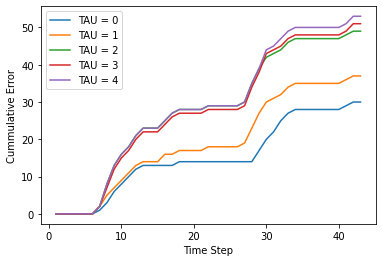

In [20]:
'''
More data processing
'''
# sum up the negative costs for the tower (get total expiration value)
cost_per_tau_over_time = [[] for i in range(TAU_MAX)]
for index,tau in enumerate(completed_states):
    sum_cost = 0
    for time_step in range(len(completed_states[0][0])):
        for tower in tau:
            for expiration in tower[time_step].time_vector:
                if expiration < 0:
                    sum_cost -= expiration 
        cost_per_tau_over_time[index].append(sum_cost)
cost_per_tau_over_time = cost_per_tau_over_time[:5]
'''
first plot:
cummulative expiration cost vs. time step
label with periods of high traffic and low traffic
do a line per tau
'''
import matplotlib.pyplot as plt
x = [i+1 for i in range(len(completed_states[0][0]))]
for tau_num, tau in enumerate(cost_per_tau_over_time):
    plt.plot(x, tau, label = "TAU = " + str(tau_num))
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Cummulative Error')
plt.show()